# Clustering Text

In [17]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="train",
    categories=categories,
    shuffle=True,
    random_state=42,
)

# load the data
data = {'text': dataset.data, 'target': dataset.target}
df = pd.DataFrame(data)
df

,text,target
0,"Hi,\n\nI've noticed that if you only save a mo...",1
1,"\n\nSeems to be, barring evidence to the contr...",3
2,\n >In article <1993Apr19.020359.26996@sq.sq.c...,2
3,I have a request for those who would like to s...,0
4,AW&ST had a brief blurb on a Manned Lunar Exp...,2
...,...,...
2029,\n Did the Russian spacecraft(s) on the ill-f...,2
2030,"\n\nOh gee, a billion dollars! That'd be just...",2
2031,I am looking for software to run on my brand n...,1
2032,\n\nThis is becoming a tiresome statement. Co...,0


In [62]:
# look at one example from the data
df.text[4]

'AW&ST  had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th  at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this?  How much, to attend????\n\nAnyone want to go?'

In [63]:
#!pip install nltk

In [83]:
import nltk
import regex as re

def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    return text

# clean the text
df['text_cleaned'] = df['text'].apply(lambda text: preprocess_text(text))
df = df[df['text_cleaned'] != '']
df = df.reset_index(drop=True)
df

,text,target,text_cleaned,cluster_tfidf,x0_tfidf,x1_tfidf
0,"Hi,\n\nI've noticed that if you only save a mo...",1,Hi I ve noticed that if you only save a model ...,2,-0.091748,-0.081819
1,"\n\nSeems to be, barring evidence to the contr...",3,Seems to be barring evidence to the contrary ...,2,0.040607,-0.036888
2,\n >In article <1993Apr19.020359.26996@sq.sq.c...,2,In article Apr sq sq com msb sq sq com Mark B...,2,-0.004494,-0.029268
3,I have a request for those who would like to s...,0,I have a request for those who would like to s...,3,0.022644,0.003082
4,AW&ST had a brief blurb on a Manned Lunar Exp...,2,AW ST had a brief blurb on a Manned Lunar Expl...,2,-0.038099,0.012571
...,...,...,...,...,...,...
1982,I am working on a program to display 3d wirefr...,1,I am working on a program to display d wirefra...,2,-0.123716,0.000599
1983,\n Did the Russian spacecraft(s) on the ill-f...,2,Did the Russian spacecraft s on the ill fated...,2,-0.113019,0.031241
1984,"\n\nOh gee, a billion dollars! That'd be just...",2,Oh gee a billion dollars That d be just about...,2,-0.008905,0.018862
1985,I am looking for software to run on my brand n...,1,I am looking for software to run on my brand n...,2,-0.139923,-0.074712


In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

# make numbers out of words -> necessary for calculating with them
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    max_df=0.5,     # ignore terms that appear in more than max_df% of the documents
    min_df=5,       # term must be present in at least min_df documents
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(df['text_cleaned']).toarray()

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.112 s
n_samples: 1987, n_features: 5108


In [85]:
from sklearn.decomposition import PCA

# reduce to two dimensions for plotting
def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    df.loc[:,f'x0_{method}'] = x0 
    df.loc[:,f'x1_{method}'] = x1

In [86]:
#!pip install seaborn
#!pip install matplotlib

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# define how to plot
def plot_pca(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

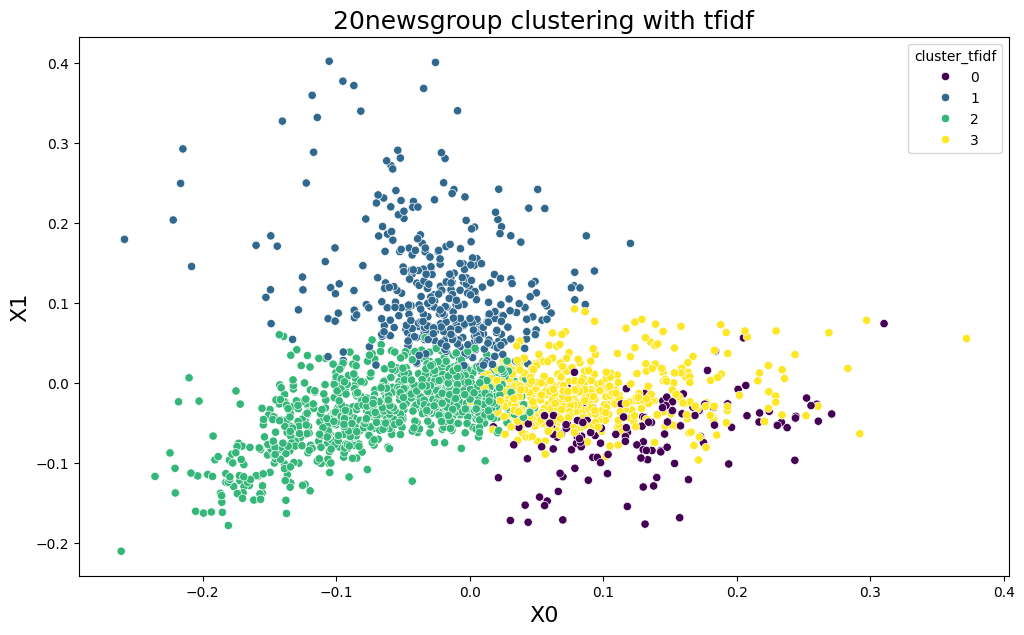

In [88]:
from sklearn.cluster import KMeans

# cluster the data and plot all clusters
for embedding_and_method in [(X_tfidf, 'tfidf')]: #, (X_transformers, 'transformers'), (X_glove, 'glove'), ((X_cls_bert, 'Bert-CLS')) ]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]

    # initialize kmeans with 3 centroids
    kmeans = KMeans(n_clusters=4, random_state=42)

    # fit the model
    kmeans.fit(embedding)

    # store cluster labels in a variable
    clusters = kmeans.labels_

    # Assign clusters to our dataframe
    clusters_result_name = f'cluster_{method}'
    df.loc[:,clusters_result_name] = clusters

    #eval_cluster(embedding)
    dimension_reduction(embedding, method)
    plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)

## Evaluation

In [89]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score

def eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)
    
    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(df["target"], y_pred)
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))

In [90]:
eval_cluster(X_tfidf)

Adjusted Rand Index (ARI): 0.309
Normalized Mutual Information (NMI): 0.356
Fowlkes-Mallows Index (FMI): 0.515


In [91]:
from sklearn.metrics import f1_score

y_pred = kmeans.fit_predict(X_tfidf)
f1_score(y_true= df['target'], y_pred=y_pred, average='macro')

0.22404795426024204

In [92]:
df

,text,target,text_cleaned,cluster_tfidf,x0_tfidf,x1_tfidf
0,"Hi,\n\nI've noticed that if you only save a mo...",1,Hi I ve noticed that if you only save a model ...,2,-0.091748,-0.081819
1,"\n\nSeems to be, barring evidence to the contr...",3,Seems to be barring evidence to the contrary ...,2,0.040607,-0.036888
2,\n >In article <1993Apr19.020359.26996@sq.sq.c...,2,In article Apr sq sq com msb sq sq com Mark B...,2,-0.004494,-0.029268
3,I have a request for those who would like to s...,0,I have a request for those who would like to s...,3,0.022644,0.003082
4,AW&ST had a brief blurb on a Manned Lunar Exp...,2,AW ST had a brief blurb on a Manned Lunar Expl...,2,-0.038099,0.012571
...,...,...,...,...,...,...
1982,I am working on a program to display 3d wirefr...,1,I am working on a program to display d wirefra...,2,-0.123716,0.000599
1983,\n Did the Russian spacecraft(s) on the ill-f...,2,Did the Russian spacecraft s on the ill fated...,2,-0.113019,0.031241
1984,"\n\nOh gee, a billion dollars! That'd be just...",2,Oh gee a billion dollars That d be just about...,2,-0.008905,0.018862
1985,I am looking for software to run on my brand n...,1,I am looking for software to run on my brand n...,2,-0.139923,-0.074712


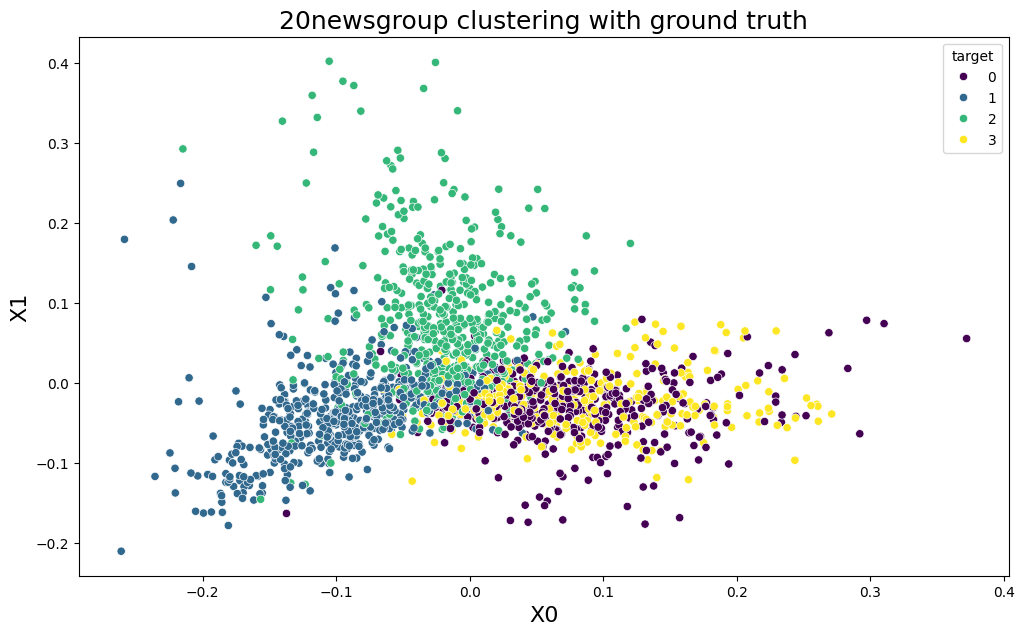

In [93]:
plot_pca(f'x0_{method}', f'x1_{method}', cluster_name="target", method="ground truth")